# A demonstration to use personalized PCA to handle thermal measurement data

##Prerequisite
load all needed packages. You may need to change GOOGLE_DRIVE_PATH_AFTER_MYDRIVE to your own drive name. If there are some issues, you may consider copy everything into your own google drive.

In [1]:
import copy
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import os
#import torch.nn.utils.parametrizations 

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "/content/drive/My Drive/projects/thermal/simplified"
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))


import sys
sys.path.append(GOOGLE_DRIVE_PATH)

from solver import *


Mounted at /content/drive
['images', 'README.md', 'torchimgpro.py', 'solver.py', 'postprocessing.py', 'proprocess.m', 'main.ipynb', '__pycache__']


##Step 1
define the hyper-parameters.

Some parameters you can tune include:

ngc: the number of global components, make it larger if you want to capture more common information

nlc: the number of local components.

momentum: change it to 1 if you want to apply perPCA on Fourier transformed features.

reshuffle: change to 1 if you want to [dilate the pixels](https://iq.opengenus.org/dilated-convolution/) 



In [2]:
args = {
            "ngc":15,
            "nlc":50,
            "optim":"SGD",
            "lr":0.05,
            "epochs":400,
            "seed":100,
            "lbd_s":1e4,
            "wd":0,
            "normalize":1,
            "columnnorm":1,
            "momentum":0,
            "reshuffle":1,
        }
        
       
print(args)
np.random.seed(args["seed"])
torch.manual_seed(args["seed"])

{'ngc': 15, 'nlc': 50, 'optim': 'SGD', 'lr': 0.05, 'epochs': 400, 'seed': 100, 'lbd_s': 10000.0, 'wd': 0, 'normalize': 1, 'columnnorm': 1, 'momentum': 0, 'reshuffle': 1}


##Step 2
Load data and preprocess

In [3]:
import torchimgpro 
Yraw = torchimgpro.load_thermal_data(GOOGLE_DRIVE_PATH, dict())
for bd in Yraw:
  for ly in Yraw[bd]:
      Y = Yraw[bd][ly]
      break


if args["momentum"]:
  Y = torchimgpro.position2momentum(Y)
if args["reshuffle"]:
  for i in Y.keys():
    args["n1"] = 10
    args["n2"] = 10
    n1 = args["n1"]
    n2 = args["n2"]
    (d1,d2) = Y[i].shape
    break
  args["k1"] = d1 // n1
  args["k2"] = d2 // n2
  Y = {ki:torchimgpro.reshuffle(Y[ki], n1, n2) for ki in Y.keys()}

if isinstance(Y, list):
  N = len(Y)
  alliters = list(range(N))
else:
  alliters = Y.keys()
  N = len(alliters)
  
for ki in Y.keys(): 
  print(Y[ki].shape)
  break
       

norms = dict()
transmat = []

if args["normalize"]:
  print("normalize data")
  with torch.no_grad():
    for i in Y.keys():
      ni = []
      if args["columnnorm"]:
        for j in range(len(Y[i])):
          normy = Y[i][j].norm()+1e-10
          Y[i][j] /= normy
          ni.append(normy)
          norms[i]=ni
      else:
        for j in range(len(Y[i][0])):
          normy = Y[i][:,j].norm()
          Y[i][:,j] /= normy
          ni.append(normy)
          norms[i]=ni

339 files loaded from /content/drive/My Drive/projects/thermal/simplified/images/
1 361 225
1 363 114
torch.Size([266, 100])
normalize data


##Step 3
train personalized PCA, this can take several minutes. The loss should decrease to below 0.1

In [4]:
Ug,Vg,Ul,Vl = lg_matrix_factorization_projgd(Y, args)

[0/400], loss 43.736918453640406, time 0.5343897342681885
[1/400], loss 43.649543067084416, time 0.367811918258667
[2/400], loss 43.55452016194661, time 0.37250208854675293
[3/400], loss 43.42052998860677, time 0.38678407669067383
[4/400], loss 43.219806009928384, time 0.3748190402984619
[5/400], loss 42.92893889533149, time 0.3700070381164551
[6/400], loss 42.542868287828234, time 0.3815116882324219
[7/400], loss 42.07966843499078, time 0.38776659965515137
[8/400], loss 41.562436972724065, time 0.37412142753601074
[9/400], loss 40.99777488708496, time 0.382920503616333
[10/400], loss 40.37524028354221, time 0.38848876953125
[11/400], loss 39.68424757215712, time 0.37616896629333496
[12/400], loss 38.928729697333445, time 0.36704587936401367
[13/400], loss 38.11342119852702, time 0.50020432472229
[14/400], loss 37.22332059648302, time 0.6173141002655029
[15/400], loss 36.2223785993788, time 0.4933180809020996
[16/400], loss 35.041621704101566, time 0.37308430671691895
[17/400], loss 33

## Step 4: Visualize the results

Some helper functions to visualize the data. We use Altair to create interactive figures. Installation code is copied from [this demo](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/recommendation-systems/recommendation-systems.ipynb). This can take minutes and there might be an error.

In [5]:

# Install Altair and activate its colab renderer.
print("Installing Altair...")
!pip install git+git://github.com/altair-viz/altair.git
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('colab')
print("Done installing Altair.")

# Install spreadsheets and import authentication module.
USER_RATINGS = False
!pip install --upgrade -q gspread
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials


Installing Altair...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning git://github.com/altair-viz/altair.git to /tmp/pip-req-build-ph34gjrl
  Running command git clone -q git://github.com/altair-viz/altair.git /tmp/pip-req-build-ph34gjrl
  fatal: unable to connect to github.com:
  github.com[0: 140.82.121.3]: errno=Connection timed out

ERROR: Command errored out with exit status 128: git clone -q git://github.com/altair-viz/altair.git /tmp/pip-req-build-ph34gjrl Check the logs for full command output.
Done installing Altair.
     |████████████████████████████████| 40 kB 4.6 MB/s 


Some visualization code with the help of Altair

In [6]:
def simplest_visualization(source):
  selector = alt.selection_single(empty='all', fields=['name'])
  brush = alt.selection_single(encodings=['x', 'y'], on='mouseover', nearest=True, empty='none')
  
   
  points = alt.Chart(source).mark_text(filled=True, size=5).encode(
    x='x:Q',
    y='y:Q',
    text='name',
    size=alt.condition(brush, alt.value(20), alt.value(5))
  )
  
  circ = alt.Chart(source).mark_point(filled=True, size=200).encode(
    alt.X('x:Q'),
    alt.Y('y:Q'),
  ).add_selection(
    brush
  )
 
  return circ+points



import numpy as np
from numpy import linalg as LA

from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering

def subspace_error(U,V):
    pu = U@np.linalg.inv(U.T@U)@U.T    
    pv = V@np.linalg.inv(V.T@V)@V.T
    return np.linalg.norm(pu-pv)
def subspace_inner_product(U,V):
  return -np.trace(U.T@V)

def subspace_angle(U,V):
    qu,ru = np.linalg.qr(U)
    qv,rv = np.linalg.qr(V)

    Z = qu.T@qv
    u,s,vh = np.linalg.svd(Z)
    return np.mean(1-(s[0:5]))

def spectral_cluster(V, names):
    ncl = len(V)
    afm = np.zeros((ncl, ncl))
    for i in range(ncl):
        for j in range(i):
            afm[i, j] = subspace_angle(V[i], V[j])
            afm[j, i] = afm[i, j]

    maxele = np.max(afm)
    afm /= maxele
    afm = afm ** 2
    #print(afm)
    #print(afm[0])
    afm_copy = copy.deepcopy(afm)
    # cluster_plot(afm)
    for i in range(ncl):
        afm[i, i] -= afm[i].sum()
    clustering = SpectralClustering(n_clusters=2,
                                    assign_labels='discretize',
                                    random_state=0, affinity='precomputed').fit(afm)
  
    return cluster_plot(afm_copy, clustering.labels_, names)

def cluster_plot(X, clabels, names):
    from sklearn.datasets import load_digits
    from sklearn.manifold import MDS, TSNE
    
    #embedding = MDS(n_components=2)
    #X_transformed = embedding.fit_transform(X)

    #import sklearn.manifold 
    tsne = TSNE(
            n_components=2, perplexity=200, metric='cosine', early_exaggeration=10.0,
            init='pca', verbose=True, n_iter=400)

    print('Running t-SNE...')
    X_transformed = tsne.fit_transform(X)
    return X_transformed

### Post processing
Define some helper functions to show multiple images

In [7]:
import matplotlib.pyplot as plt
import torchvision

# functions to show an image
def imshow(images, nrow=4):
    #img = img / 2 + 0.5     # unnormalize
    img = torchvision.utils.make_grid(images,nrow=nrow)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

def figsshow(idx):
  row1 = [reconstruct_bg[i].unsqueeze(0)/torch.max(reconstruct_bg[i]) for i in idx]
  row2 = [reconstruct_cat[i].unsqueeze(0)/torch.max(reconstruct_cat[i]) for i in idx]
  row3 = [Y[i].unsqueeze(0)/torch.max(Y[i]) for i in idx]
  imshow(row3+row1+row2,nrow=len(idx))
  print(idx)



Run it every time you rerun perPCA

In [9]:

names = [ki for ki in Y.keys()]

Vlist = [Vl[ki].lin_mat.detach().numpy() for ki in Y.keys()]

with torch.no_grad():
  reconstruct_bg = {i:(Ug[i].lin_mat@Vg[i].lin_mat.T) for i in alliters}
  reconstruct_cat = {i:(Ul[i].lin_mat@Vl[i].lin_mat.T) for i in alliters}        
  for i in alliters:            
    if args["normalize"]:
      if args["columnnorm"]:
        for j in range(len(reconstruct_bg[i])):
          reconstruct_bg[i][j] *= norms[i][j]
          reconstruct_cat[i][j] *= norms[i][j]
          Y[i][j] *= norms[i][j].item()
      else:
        for j in range(len(reconstruct_bg[i][0])):
          reconstruct_bg[i][:,j] *= norms[i][j]
          reconstruct_cat[i][:,j] *= norms[i][j]
          Y[i][:,j] *= norms[i][j]
    if args['reshuffle']: 
        reconstruct_bg[i] = torch.tensor(torchimgpro.shuffleback(reconstruct_bg[i], args["n1"], args["n2"], args["k1"], args["k2"]))   
        reconstruct_cat[i] = torch.tensor(torchimgpro.shuffleback(reconstruct_cat[i], args["n1"], args["n2"], args["k1"], args["k2"]))    
        Y[i] = torch.tensor(torchimgpro.shuffleback(Y[i], args["n1"], args["n2"], args["k1"], args["k2"]))    




/content/drive/My Drive/projects/thermal/simplified/torchimgpro.py:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return fd(torch.tensor(Ys).unsqueeze(0)).numpy()[0][0]


Spectral cluster and tSNE

In [10]:
xt = spectral_cluster(Vlist, names)

print('spectral clustering finished')



Running t-SNE...
[t-SNE] Computing 224 nearest neighbors...
[t-SNE] Indexed 225 samples in 0.001s...
[t-SNE] Computed neighbors for 225 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 225 / 225
[t-SNE] Mean sigma: 0.282834


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 33.272976
[t-SNE] KL divergence after 400 iterations: 0.070046
spectral clustering finished


Create a dataframe with the data (this can take a few minites)

In [11]:
alltuples = []
tot = xt.shape


import pandas as pd
alltuples = {
    'name':names,
    'x':xt[:,0],
    'y':xt[:,1],
}    
source = pd.DataFrame(alltuples, columns =['name','x','y'])

Visualize Data. Visualizations can differ due to different inputs.

In [12]:
chart = simplest_visualization(source)
chart.save('chart.html')
chart

alt.LayerChart(...)

Show the results of some images. Input the image index as a list, the following function will output three rows of images. The first row corresponds to the global factors, the second row corresponds to the local factors, and the third row corresponds to the original images.

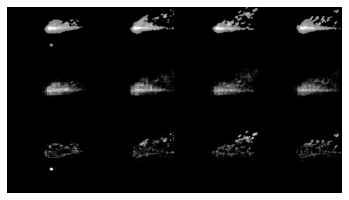

[445, 3080, 2745, 1380]


In [ ]:
figsshow([445, 3080, 2745, 1380])

# Additional Step
Rerun the experiments using sinple PCA, i.e. we do not share anything and use completely localized PCA to determine the local subspaces.

Firstly, reload data.

In [ ]:
Yraw = torchimgpro.load_thermal_data(GOOGLE_DRIVE_PATH, dict())
for bd in Yraw:
  for ly in Yraw[bd]:
      Y1 = Yraw[bd][ly]
      break
        #Y = Y[:5]
        #print("a2")

if args["momentum"]:
  Y1 = torchimgpro.position2momentum(Y1)
if args["reshuffle"]:
  for i in Y1.keys():
    args["n1"] = 10
    args["n2"] = 10
    n1 = args["n1"]
    n2 = args["n2"]
    (d1,d2) = Y1[i].shape
    break
  args["k1"] = d1 // n1
  args["k2"] = d2 // n2
  Y1 = {ki:torchimgpro.reshuffle(Y1[ki], n1, n2) for ki in Y1.keys()}

if isinstance(Y1, list):
  N = len(Y1)
  alliters = list(range(N))
else:
  alliters = Y1.keys()
  N = len(alliters)
  
for ki in Y1.keys(): 
  print(Y1[ki].shape)
  break
       

norms = dict()
transmat = []
if args["normalize"]:
  print("normalize data")
  with torch.no_grad():
    for i in Y1.keys():
      ni = []
      if args["columnnorm"]:
        for j in range(len(Y1[i])):
          normy = Y1[i][j].norm()+1e-10
          Y1[i][j] /= normy
          ni.append(normy)
          norms[i]=ni
      else:
        for j in range(len(Y1[i][0])):
          normy = Y1[i][:,j].norm()
          Y1[i][:,j] /= normy
          ni.append(normy)
          norms[i]=ni
                        
            

225 files loaded from /content/drive/My Drive/projects/thermal/images_ds/test1_thermal/
1 361 225
torch.Size([266, 100])
normalize data


Then run localized PCA

In [ ]:
U_nofl = dict()
V_nofl = dict()
U_nofl_list = []
names_nofl = [] 
for i in Y1:
  ui, si, vhi = np.linalg.svd(Y1[i].numpy())
  ui = ui[:,:args['ngc']]
  U_nofl[i] = ui
  V_nofl[i] = vhi
  U_nofl_list.append(ui)
  names_nofl.append(i)



And cluster the column spaces

In [ ]:
xt_nofl = spectral_cluster(U_nofl_list, names)

print('spectral clustering finished')
alltuples_nofl = {
    'name':names_nofl,
    'x':xt_nofl[:,0],
    'y':xt_nofl[:,1],
}    
source_nofl = pd.DataFrame(alltuples_nofl, columns =['name','x','y'])
simplest_visualization(source_nofl)

[0.00000000e+00 1.00760713e-05 9.40510133e-06 6.06835261e-06
 6.25237105e-09 9.32715071e-06 3.08805626e-09 2.86762980e-04
 1.34825829e-06 1.35879059e-06 8.51473287e-07 5.29772485e-06
 5.65083554e-07 1.00136626e-05 0.00000000e+00 1.58055143e-05
 1.94018362e-03 1.07547131e-04 9.64062960e-04 1.26352638e-04
 2.27581839e-05 2.25432487e-05 4.62963491e-03 9.36644454e-04
 1.26547422e-02 2.06622508e-03 1.77689485e-02 1.42776437e-03
 5.14697701e-03 2.28000432e-01 8.56922684e-03 7.01432212e-05
 1.13517566e-03 9.00690505e-04 3.53817085e-03 2.75711253e-03
 4.29890708e-03 9.33560658e-05 1.17239949e-04 4.92359069e-04
 2.93575713e-02 3.82173859e-03 1.39857934e-01 4.74468333e-02
 4.46332101e-02 2.98932724e-04 1.93797078e-02 5.62895355e-02
 5.32545690e-02 1.14296682e-02 1.41533175e-01 1.32597332e-01
 3.39301328e-02 6.45054669e-03 7.85952217e-02 3.90338337e-02
 1.32519959e-01 3.37855424e-02 4.34270356e-02 5.32047416e-03
 6.78563440e-02 1.58616885e-01 1.06943699e-01 3.36987204e-02
 1.05532742e-01 3.966776

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 31.848890
[t-SNE] KL divergence after 400 iterations: 0.009396
spectral clustering finished


alt.LayerChart(...)

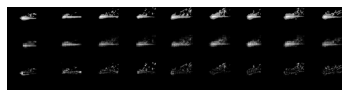

[610, 3605, 3170, 2170, 1890, 1655, 3070, 1460, 1105]


In [ ]:
figsshow([610, 3605, 3170, 2170, 1890, 1655, 3070, 1460, 1105])